<a href="https://colab.research.google.com/github/aidanhaurin/CSC370-Final-Project/blob/main/AHaurin_NMaye_CSC370_Group_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aidan Haurin and Nicholas Maye <br/>
May 6th, 2024 <br/>
CSC370 Final Project

Before any networks can be made we need to download the data and split it into training, validation, and testing sets

In [ ]:
# You will need to import the .JSON file through drive
# This may require making a folder in Google Drive called "mountingfolder"
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/mountingfolder'

Mounted at /content/drive
/content/drive/My Drive/mountingfolder


In [ ]:
# Various imports we will need throughout the project
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from matplotlib import pyplot as plt

In [ ]:
import json
import colorsys

# Function to get RGB values from string
def hexRGB(hex):
    # Remove hashtag
    hex = hex[1:]

    # In a hexadecimal code, every two digits is one color channel
    # So in #012345, 01 is the red channel, 23 the green and 45 the blue channel.
    # Split rest of string into three parts
    # Convert parts of the remaining string into separate integer values
    rgb = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

    # Normalize RGB values to be between 0 and 1
    R, G, B = [x / 255.0 for x in rgb]

    return R, G, B

# Function to get HSV values from string
def hexHSV(hex):
    # Remove hashtag
    hex = hex[1:]

    # Split rest of string into three parts
    # Convert parts of the remaining string into separate integer values
    rgb = tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

    # Normalize RGB values to be between 0 and 1
    r, g, b = [x / 255.0 for x in rgb]

    # Convert RGB to HSV using colorsys library
    hsv = colorsys.rgb_to_hsv(r, g, b)

    # Separate HSV values
    H, S, V = hsv
    return H, S, V

# 11 categories: black, grey, white, red, orange, yellow, green, blue, purple, pink and brown
lis_col = ["black", "gray", "white", "red", "orange", "yellow", "green", "blue", "purple", "pink", "brown"]

# https://huggingface.co/datasets/burkelibbey/colors/blob/main/colors.jsonl
# ^---- download this and change the file extension from .jsonl to .json
# then upload the file into a folder on your Google Drive named "mountingfolder"
filepath = "/content/drive/My Drive/mountingfolder/colors.json"

data = []                                        # make list for dict objects
with open(filepath) as f:                        # load the JSON
    for line in f:                               # loop through each line
        data.append(json.loads(line))            # add new object

# Next we will loop through our dictionaries added in data list

dataset = []
for i in range(len(data)):
    # get index for each color word in desc
    # the first color word becomes the description in dataset

    strdesc = ""                                              # Start with empty string
    found = False                                             # Boolean to know if word found
    j = len(data[i]['description'])-1
    for color in lis_col:                                     # Go through each color category
      try:
        indcol = data[i]['description'].lower().find(color)   # Look for index of the color word
        if (indcol < j) and (indcol > -1):                    # Update index j before going to next category
            strdesc = color                                   # If the index of a category is before j, update
            j = indcol                                        # the category and j index to the new one
            found = True
      except:
        continue   # If finding the index gives an error, we skip this entry

    # No color words found; skip this entry
    if(found == False): continue

    # make new dictionary entry and add it to dataset
    # ---------------------- NOTE: ----------------------
    # To test either RGB or HSV channels, you will
    # need to change the function in "channels" to either
    # hexRGB or hexHSV
    entry = {
        "hexcode": data[i]['color'],                                      # hexadecimal color code
        "channels": np.asarray(hexHSV(data[i]['color'])),                 # color channels in nparray form
        "color word": strdesc,                                            # color category
        "labels": lis_col.index(strdesc)/10                               # color category in nparray label form
    }

    dataset.append(entry)

# To test if the list worked, pick a bunch of random entries
# and show their information
x  = np.arange(stop=len(dataset), step=np.random.randint(4000,4500)).tolist()
print(f"Random sampling: \n{x}\n")
for i in x:
  print(f"{dataset[i]}")

# Show total number of entries made (32844)
# The JSON has 33,887 entries, so the conversion has worked pretty well
print(f"\nThere are {len(dataset)} entries.")

Random sampling: 
[0, 4450, 8900, 13350, 17800, 22250, 26700, 31150]

{'hexcode': '#000000', 'channels': array([0., 0., 0.]), 'color word': 'black', 'labels': 0.0}
{'hexcode': '#224430', 'channels': array([0.40196078, 0.5       , 0.26666667]), 'color word': 'green', 'labels': 0.6}
{'hexcode': '#4477cc', 'channels': array([0.60416667, 0.66666667, 0.8       ]), 'color word': 'blue', 'labels': 0.7}
{'hexcode': '#66a000', 'channels': array([0.22708333, 1.        , 0.62745098]), 'color word': 'green', 'labels': 0.6}
{'hexcode': '#88d020', 'channels': array([0.23484848, 0.84615385, 0.81568627]), 'color word': 'green', 'labels': 0.6}
{'hexcode': '#addcce', 'channels': array([0.45035461, 0.21363636, 0.8627451 ]), 'color word': 'blue', 'labels': 0.7}
{'hexcode': '#d03060', 'channels': array([0.95      , 0.76923077, 0.81568627]), 'color word': 'pink', 'labels': 0.9}
{'hexcode': '#f070d0', 'channels': array([0.875     , 0.53333333, 0.94117647]), 'color word': 'pink', 'labels': 0.9}

There are 328

In [ ]:
# Make new lists from our dataset; add information from the dataset
list_channels = []
list_labels = []

for i in range(len(dataset)):
  list_channels.append(dataset[i]["channels"])
  list_labels.append(dataset[i]["labels"])

# Convert channels list to arrays and reshape them to fit the model
arr_channels = np.asarray(list_channels)
arr_channels = arr_channels.reshape(32844, 1, 3)

# Make a dataset class
class ColorDataset(Dataset):
    def __init__(self, inputs, color_categories):
        self.inputs = inputs
        self.color_categories = color_categories

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.color_categories[idx], dtype=torch.long)

# Make dataset class instance
cds = ColorDataset(arr_channels, list_labels)

#verify the dataset works
print(len(cds))
print(cds.inputs)
print(cds.color_categories)

32844
[[[0.         0.         0.        ]]

 [[0.66666667 1.         0.0627451 ]]

 [[0.66666667 1.         0.06666667]]

 ...

 [[0.16666667 0.06666667 1.        ]]

 [[0.16666667 0.05882353 1.        ]]

 [[0.         0.         1.        ]]]
[0.0, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.0, 0.0, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.0, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.7, 0.6, 0.7, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7

In [ ]:
# Using pyTorch because Keras might be too slow
torch.manual_seed(0)
np.random.seed(123)

# Split the data into training, validation, testing sets
# 60% training, 20% validation, 20% testing
split_ratio = 0.2
idx = list(range(len(cds)))
np.random.shuffle(idx)
split_size = int(np.floor(split_ratio * len(cds)))
temp_set, test_set = idx[split_size:], idx[:split_size]
train_set, valid_set = temp_set[split_size:], temp_set[:split_size]

# Get samples from the new sets
train_sample = SubsetRandomSampler(train_set)
valid_sample = SubsetRandomSampler(valid_set)
test_sample = SubsetRandomSampler(test_set)

# This batch size will be used throughout the project
# The project is small-scale so a bigger value will process data extremely fast
batch_size = 256

# Create loaders for all subsets
train_loader = DataLoader(cds, batch_size=batch_size, sampler=train_sample)
valid_loader = DataLoader(cds, batch_size=batch_size, sampler=valid_sample)
test_loader = DataLoader(cds, batch_size=batch_size, sampler=test_sample)

# Show the length of the dataset and subsets
print(f"Load dataset size: {len(cds)}")
print(f"Training dataset size: {len(train_set)}")
print(f"Validation dataset size: {len(valid_set)}")
print(f"Test dataset size: {len(test_set)}")

# Show shape of input and labels
for step, (input, labels) in enumerate(train_loader, 1):
  print()
  print(f"{input.shape}")
  print(input[0])
  print(f"{labels.shape}")
  print(labels[0])
  break

Load dataset size: 32844
Training dataset size: 19708
Validation dataset size: 6568
Test dataset size: 6568

torch.Size([256, 1, 3])
tensor([[0.8842, 0.8745, 1.0000]])
torch.Size([256])
tensor(0)


Below is the actual Convolutional Neural Network model.

In [ ]:
# Create the model for the convolutional neural network
class hexNet(nn.Module):
    # Initialize the network
    def __init__(self):
      # Extend Module
      super().__init__()
      # Define the specific layers
      # bias in Convolution layers is disabled since we are using batch normalization
      self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=1, bias=False)
      self.conv2 = nn.Conv1d(in_channels=16, out_channels=128, kernel_size=1, bias=False)

      self.fc1 = nn.Linear(128, 64)
      self.batch1 = nn.BatchNorm1d(64)
      self.fc2 = nn.Linear(64, 32)
      self.batch2 = nn.BatchNorm1d(32)
      self.fc3 = nn.Linear(32, 11)

      # Define the general/repeated functions
      self.relu = nn.ReLU()
      self.pool = nn.AvgPool1d(kernel_size=1, stride=2)
      self.flatten = nn.Flatten()

    def forward(self, x):
      # Forward pass
      # Convolution --> ReLU --> Pooling Layers
      x = self.pool(self.relu(self.conv1(x)))
      x = self.pool(self.relu(self.conv2(x)))

      # Flatten values for Fully-Connected Layers
      x = self.flatten(x)

      # Fully-Connected --> Batch-Normalized --> ReLU layers
      x = self.relu(self.batch1(self.fc1(x)))
      x = self.relu(self.batch2(self.fc2(x)))
      x = self.relu(self.fc3(x))
      return x

# Create the network and show its functions
model = hexNet()
print(model)

hexNet(
  (conv1): Conv1d(1, 16, kernel_size=(1,), stride=(1,), bias=False)
  (conv2): Conv1d(16, 128, kernel_size=(1,), stride=(1,), bias=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (batch1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=11, bias=True)
  (relu): ReLU()
  (pool): AvgPool1d(kernel_size=(1,), stride=(2,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [ ]:
# Install torchinfo library
!pip install torchinfo

In [ ]:
# View model summary
from torchinfo import summary

# input_size is the dimensions of the ColorDataset class input (batch_size, 1, 3)
summary(model, input_size=(batch_size, 1, 3))

Layer (type:depth-idx)                   Output Shape              Param #
hexNet                                   [256, 11]                 --
├─Conv1d: 1-1                            [256, 16, 3]              16
├─ReLU: 1-2                              [256, 16, 3]              --
├─AvgPool1d: 1-3                         [256, 16, 2]              --
├─Conv1d: 1-4                            [256, 128, 2]             2,048
├─ReLU: 1-5                              [256, 128, 2]             --
├─AvgPool1d: 1-6                         [256, 128, 1]             --
├─Flatten: 1-7                           [256, 128]                --
├─Linear: 1-8                            [256, 64]                 8,256
├─BatchNorm1d: 1-9                       [256, 64]                 128
├─ReLU: 1-10                             [256, 64]                 --
├─Linear: 1-11                           [256, 32]                 2,080
├─BatchNorm1d: 1-12                      [256, 32]                 64
├─ReL

In [ ]:
# Check to see if GPU can be used and pass device as input to CNN model, create device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = hexNet().to(device)

# Create the loss function
loss_func = nn.CrossEntropyLoss()

# Create the learning rate and Adagrad optimizer
learning_rate = 0.01
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
import datetime

# Perform one-hot encoding on color labels
# Length is 11 because we have 11 categories
def one_hot_encoder(labels, length=11):
    output = torch.zeros(labels.size(dim=0), length)
    for idx, row in enumerate(output):
        row[labels[idx]] = 1
    return output

# Perform the metric function on predicitions and color labels
def metric_func(pred, labels):
    correct = (pred.argmax(1) == labels).type(torch.float).sum().item()
    accuracy = correct / pred.size(0)
    return accuracy

# Train the neural network during one epoch
def train_step(model, inputs, labels, loss_func, optimizer, device):
    # Put model in training mode
    model.train()

    # Reset the optimizer
    optimizer.zero_grad()

    # Pass device information to channels and color labels
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Create predictions with the CNN model and one-hot encoding
    predictions = model(inputs)
    labels_one_hot = one_hot_encoder(labels)

    # Calculate the loss of the predictions, then pass the predictions to the metric function
    loss = loss_func(predictions, labels_one_hot.to(device))
    metric = metric_func(predictions, labels)

    # Perform backward propagation on loss data
    loss.backward()

    # Apply optimizer to the next training step
    optimizer.step()

    # Return the loss data and result of the metric function
    return loss.item(), metric

def valid_step(model, inputs, labels, loss_func, device):
    # Put model in evaluation mode
    model.eval()

    # Pass device information, hex codes and color labels
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Create predictions with the CNN model and one-hot encoding, then pass to metric function
    with torch.no_grad():
        predictions = model(inputs)
        labels_one_hot = one_hot_encoder(labels)
        loss = loss_func(predictions, labels_one_hot.to(device))
        metric = metric_func(predictions, labels)

    # Return the loss data and result of the metric function
    return loss.item(), metric

# Perform training process on the neural network
def train_model(train_loader, valid_loader, model, loss_func, optimizer, epochs, device, log_step_freq):
    # Create the four arrays for training and validation data
    metric_info={}
    metric_info['train_loss_list'] = []
    metric_info['train_acc_list'] = []
    metric_info['val_loss_list'] = []
    metric_info['val_acc_list'] = []

    # Establish the start of training
    print("Start training...")
    start_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("==========" * 8 + "%s"%start_time)

    # Loop over and train the data for specified number of epochs
    for epoch in range(1, epochs + 1):

        # Establish the training loss sum, training accuracy sum, and step
        loss_sum = 0.0
        acc_sum = 0.0
        step = 1

        # Loop over the training data
        for step, (input, labels) in enumerate(train_loader, 1):
            loss, acc = train_step(model, input, labels, loss_func, optimizer, device)

            # Print out the batch logs
            loss_sum += loss
            acc_sum += acc
            if step % log_step_freq == 0:
                print(("[step = %d] train_loss: %.4f, " + "train_acc: %.4f") % (step, loss_sum/step, acc_sum/step))

        # Establish the validation loss sum, validation accuracy sum, and step
        val_loss_sum = 0.0
        val_acc_sum = 0.0
        val_step = 1

        # Loop over the validation data
        for val_step, (input, labels) in enumerate(valid_loader, 1):
            val_loss, val_acc = valid_step(model, input, labels, loss_func, device)

            val_loss_sum += val_loss
            val_acc_sum += val_acc

        # Show the accuracy sum after total number of steps
        print(("acc_sum: %.4f step: %d")%(acc_sum, step))

        # Save the epoch logs
        metric_info['train_loss_list'].append(loss_sum/step)
        metric_info['train_acc_list'].append(acc_sum/step)
        metric_info['val_loss_list'].append(val_loss_sum/val_step)
        metric_info['val_acc_list'].append(val_acc_sum/val_step)

        # Print out the epoch logs
        print(("\nEpoch = %d, train_loss = %.4f," + \
               " train_acc = %.4f, val_loss = %.4f, " + "val_acc = %.4f")
              %(epoch,  metric_info['train_loss_list'][epoch - 1],
                metric_info['train_acc_list'][epoch - 1],
                metric_info['val_loss_list'][epoch - 1],
                metric_info['val_acc_list'][epoch - 1]))
        end_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n" + "==========" * 8 + "%s"%end_time)

    # Establish the end of training
    print('Finished training')

    # Return all four training and validation arrays
    return metric_info

# Set a number of epochs to go through
epochs = 20

# Call the training model with established neural network information
history = train_model(train_loader, valid_loader, model, loss_func, optimizer, epochs, device, log_step_freq=20)

# Save the model parameters and load parameters later
torch.save(model.state_dict(), "/content/drive/My Drive/mountingfolder/saved_models/model_parameter.pkl")
model_clone = hexNet().to(device)
model_clone.load_state_dict(torch.load("/content/drive/My Drive/mountingfolder/saved_models/model_parameter.pkl"))

Start training...
================================================================================2024-05-06 13:44:34
[step = 20] train_loss: 0.1160, train_acc: 0.9574
[step = 40] train_loss: 0.1215, train_acc: 0.9547
[step = 60] train_loss: 0.1191, train_acc: 0.9549
acc_sum: 73.4994 step: 77

Epoch = 1, train_loss = 0.1180, train_acc = 0.9545, val_loss = 0.1160, val_acc = 0.9562

================================================================================2024-05-06 13:44:36
[step = 20] train_loss: 0.1258, train_acc: 0.9535
[step = 40] train_loss: 0.1207, train_acc: 0.9531
[step = 60] train_loss: 0.1178, train_acc: 0.9536
acc_sum: 73.4993 step: 77

Epoch = 2, train_loss = 0.1174, train_acc = 0.9545, val_loss = 0.1155, val_acc = 0.9566

================================================================================2024-05-06 13:44:38
[step = 20] train_loss: 0.1227, train_acc: 0.9516
[step = 40] train_loss: 0.1170, train_acc: 0.9549
[step = 60] train_loss: 0.1166, train_acc: 0.9546


<All keys matched successfully>

Note that the graphs below on first run may look different than what was on the slides. <br/>
That's because the slides during the presentation used graphs made on a second run by mistake. <br/>
The loss starts out higher on first try but the end result is the same as on second runs. <br/>
Sorry about that! Slides have been fixed accordingly.

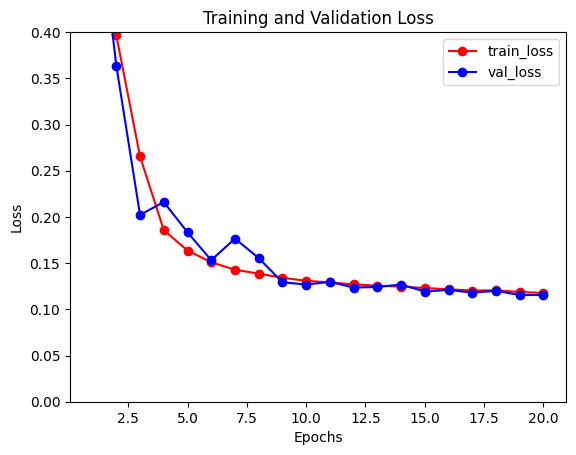

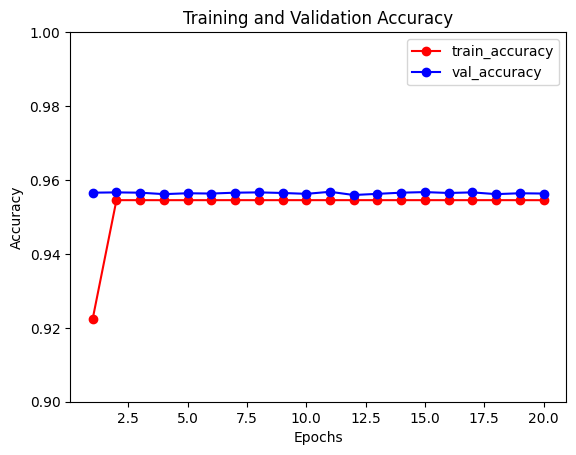

In [ ]:
# We can now graph the results
x = np.arange(1, epochs+1)                                # Make array of spaced values for x-axis

# Graph the loss of training and validation modes
plt.plot(x, history["train_loss_list"], "ro-", label="train_loss")
plt.plot(x, history["val_loss_list"], "bo-", label="val_loss")
plt.title("Training and Validation Loss")                 # Make title
plt.xlabel("Epochs")                                      # X-axis label
plt.ylabel("Loss")                                        # Y-axis label
plt.ylim(0, 0.4)                                          # Make y-axis
plt.legend(loc="upper right")                             # Set display of legend
plt.show()                                                # Display the graph
print()

# Graph the accuracy of training and validation modes
plt.plot(x, history["train_acc_list"], "ro-", label="train_accuracy")
plt.plot(x, history["val_acc_list"], "bo-", label="val_accuracy")
plt.title("Training and Validation Accuracy")             # Make title
plt.xlabel("Epochs")                                      # X-axis label
plt.ylabel("Accuracy")                                    # Y-axis label
plt.ylim(0.9, 1)                                          # Make y-axis
plt.legend(loc="upper right")                             # Set display of legend
plt.show()                                                # Display the graph

In [ ]:
# Test the saved model clone with the test dataset
test_loss_sum = 0.0
test_acc_sum = 0.0
test_step = 1

# Loop over the testing data, continuously updating the loss and accuracy sums
for test_step, (input, labels) in enumerate(test_loader, 1):
    test_loss, test_acc = valid_step(model_clone, input, labels, loss_func, device)

    test_loss_sum += test_loss
    test_acc_sum += test_acc

# Print the test accuracy and loss values
# 95%... very good
print(("test_acc = %.4f," + " test_loss = %.4f") % (test_acc_sum/test_step, test_loss_sum/test_step))

test_acc = 0.9547, test_loss = 0.1158
